Imported all required libraries

1.Numpy
2.Pandas
3.Open CV
4.Tensorflow
5.Keras
6.Matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input,MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from datetime import datetime
import pandas as pd

Using TensorFlow backend.


In [2]:
#Mounted the google colab to loacal drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#Unzipp the Dataset
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Stark - Hackathon/99505_234911_bundle_archive.zip'
with ZipFile(file_name, 'r') as zip: 
    zip.extractall() 
    print('Done!') 

Done!


Created a Identity class function to collect the all images name with path. Here collecting only Jpeg or JPG image extensions.

In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [5]:
#passing the train images path to function
train_metadata = load_metadata('/content/images/images/train')
print ('Total Train Images ', len(train_metadata))

Total Train Images  28821


In [6]:
#passing the test images path to function
validation_metadata = load_metadata('/content/images/images/validation')
print ('Total Images ', len(validation_metadata))

Total Images  7066


In [7]:
def load_image(path):
    img = cv2.imread(path, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img_rgb[:,:-1]

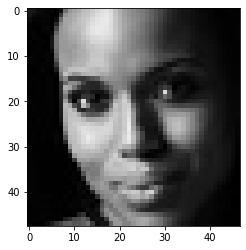

In [8]:
#Ploted the sample image
img=load_image('/content/images/images/train/neutral/9736.jpg')
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [9]:
for fec in os.listdir('/content/images/images/train'):
    print(str(len(os.listdir('/content/images/images/train/' + fec))) + " " + fec + " images")

3205 surprise images
4982 neutral images
4938 sad images
3993 angry images
7164 happy images
436 disgust images
4103 fear images


In [10]:
for fec in os.listdir('/content/images/images/' + "validation"):
    print(str(len(os.listdir('/content/images/images/' + "validation/" + fec))) + " " + fec + " images")

797 surprise images
1216 neutral images
1139 sad images
960 angry images
1825 happy images
111 disgust images
1018 fear images


In [11]:
batch_size =32
image_size=48
datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()
train_path='/content/images/images/train'
validation_path= '/content/images/images/validation'
train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(image_size,image_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(validation_path,
                                                    target_size=(image_size,image_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


CNN Architecuture 


5 CNN + RELU + MAxpooling

2 Dense Fully connected layer

1 Output layer using Softmax




In [14]:
# number of possible label values
label_classes = 7

model = Sequential()
#CNN-1 
model.add(Conv2D(32,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#CNN-2
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CNN-3
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CNN-4
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CNN-5
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(label_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

This is multi label classification so using Softmax function and categorical crossentropy as loss functions.

In [15]:
model.summary()

#Saving the model metadata
model_json = model.to_json()
with open("model_v3.json", "w") as json_file:
    json_file.write(model_json)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)       

Improvize the model accuracy using previous accuracy. Initially we have got the 60% accuracy .
Now using the previous weights to increasing accuracy.

In [ ]:
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=70,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )
model.save_weights("/content/drive/My Drive/fec_model_weights.h5")

Epoch 1/70
900/900 [==============================] - 669s 743ms/step - loss: 2.0049 - accuracy: 0.2230 - val_loss: 2.3074 - val_accuracy: 0.3114
Epoch 2/70
900/900 [==============================] - 633s 703ms/step - loss: 1.8158 - accuracy: 0.2908 - val_loss: 1.4291 - val_accuracy: 0.3934
Epoch 3/70
900/900 [==============================] - 633s 704ms/step - loss: 1.6823 - accuracy: 0.3528 - val_loss: 1.9810 - val_accuracy: 0.4099
Epoch 4/70
900/900 [==============================] - 632s 703ms/step - loss: 1.5953 - accuracy: 0.3844 - val_loss: 2.1596 - val_accuracy: 0.4342
Epoch 5/70
900/900 [==============================] - 633s 704ms/step - loss: 1.5181 - accuracy: 0.4120 - val_loss: 1.1452 - val_accuracy: 0.4721
Epoch 6/70
900/900 [==============================] - 632s 702ms/step - loss: 1.4468 - accuracy: 0.4404 - val_loss: 1.6217 - val_accuracy: 0.4869
Epoch 7/70
900/900 [==============================] - 633s 703ms/step - loss: 1.3985 - accuracy: 0.4577 - val_loss: 1.6681 -

In [16]:
model.load_weights('/content/drive/My Drive/fec_model_weights_v2.h5')

In [18]:
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=7,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size
                                )


Epoch 1/7
900/900 [==============================] - 679s 754ms/step - loss: 0.5312 - accuracy: 0.8056 - val_loss: 1.1685 - val_accuracy: 0.6409
Epoch 2/7
900/900 [==============================] - 678s 754ms/step - loss: 0.5298 - accuracy: 0.8043 - val_loss: 0.6846 - val_accuracy: 0.6483
Epoch 3/7
900/900 [==============================] - 683s 759ms/step - loss: 0.5118 - accuracy: 0.8101 - val_loss: 0.5730 - val_accuracy: 0.6432
Epoch 4/7
900/900 [==============================] - 679s 754ms/step - loss: 0.5112 - accuracy: 0.8129 - val_loss: 1.1389 - val_accuracy: 0.6315
Epoch 5/7
900/900 [==============================] - 680s 755ms/step - loss: 0.4975 - accuracy: 0.8160 - val_loss: 1.2574 - val_accuracy: 0.6483
Epoch 6/7
900/900 [==============================] - 680s 755ms/step - loss: 0.4828 - accuracy: 0.8222 - val_loss: 0.2748 - val_accuracy: 0.6405
Epoch 7/7
900/900 [==============================] - 690s 766ms/step - loss: 0.4798 - accuracy: 0.8221 - val_loss: 0.9728 - val_ac

In [21]:
model.save_weights("/content/drive/My Drive/fec_model_weights.h5")

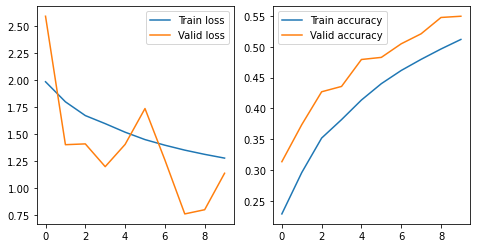

In [23]:
#First Training accuracy and Validation accuracy
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

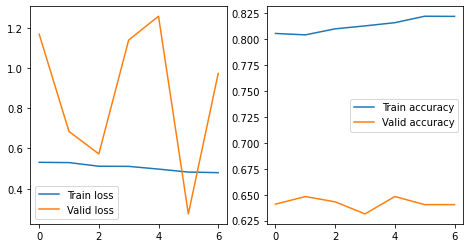

In [20]:
#Second Run and final accuracy. 
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

In [ ]:
#Save the mode wights as fec_model_weights.h5 and capturing the metadata into json.
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model_weights = model.get_weights()
model.save_weights("/content/drive/My Drive/fec_model_weights.h5")

Facemodel class is used to load the Model,Model weights and predict the emotions.

In [2]:
class Facemodel(object):

    emotions = ["Angry", "Disgust","Fear", "Happy","Neutral", "Sad","Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model._make_predict_function()

    def predicts(self, img):
        self.preds = self.loaded_model.predict(img)
        return Facemodel.emotions[np.argmax(self.preds)]

Haarcascade_frontalface_default.xml - This is used to identify the face which is widely used to detect the faces.
Loaded the CNN model and weights to model1.

In [3]:
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model1 = Facemodel("model_v2.json", "fec_model_weights_v4.h5")

real_time_capture function is used to enable webcam and predict the face emotions and identify the percentage of the emptions

In [4]:
def real_time_captre(text, cap):
    model_predictions,emoPercent,timeEmo=[],[],[]
    percent=0
    while(True):
        ret, img = cap.read()
        gray_fr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = facecascade.detectMultiScale(gray_fr, 1.3, 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        for x,y,w,h in faces:
            fc = gray_fr[y:y+h, x:x+w]
            #resize the image to 48x48
            roi = cv2.resize(fc, (48, 48))
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #Model Predictions
            pred = model1.predicts(roi[np.newaxis, :, :, np.newaxis])
            model_predictions.append(pred)
            #Percentage Calculation
            percent=round(model_predictions.count(pred)/len(model_predictions)*100,2)
            emoPercent.append(percent)
            timeEmo.append(datetime.now())
            cv2.putText(img, pred +'  ' + str(percent), (x, y), font, 1, (0, 255, 255), 2)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        
        cv2.imshow("Image", img)
        
        #Press q to quit
        if cv2.waitKey(1) == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
    return model_predictions,timeEmo,emoPercent

Video_capture function is used to play the videos and predit the emotions.

In [5]:
def video_capture(cap):
    model_pred1,emoPercent=[],[]
    model_count=0
    percent=0
    timeEmo=[]

    while(True):
        ret, img = cap.read()
        if ret == True:
            #Rezie the video windows size
            #print (img.shape)
            img1 = cv2.resize(img,(960,540),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
            gray_fr = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            font = cv2.FONT_HERSHEY_SIMPLEX
            faces = facecascade.detectMultiScale(gray_fr, 1.3, 5)
            for x,y,w,h in faces:
                fc = gray_fr[y:y+h, x:x+w]
                roi = cv2.resize(fc, (48, 48))
                #Model Prediction
                pred = model1.predicts(roi[np.newaxis, :, :, np.newaxis])
                model_pred1.append(pred)
                
                #Percentage Calculation
                percent=round(model_pred1.count(pred)/len(model_pred1)*100,2)
                
                #Capturing percentage & Time details
                emoPercent.append(percent)
                timeEmo.append(datetime.now())
                cv2.putText(img1, pred +' '+str(percent), (x, y), font, 1, (0, 255, 0), 2)
                cv2.rectangle(img1,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.imshow("Image", img1)
        else:
            break
        #Press Q to quit
        if cv2.waitKey(1) == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
    cap.release()
    cv2.destroyAllWindows()
    return model_pred1,timeEmo,emoPercent

In [21]:
#Percentage = count of emotions/Total no of predictions
emotions_list = ["Angry", "Disgust","Fear", "Happy","Neutral", "Sad","Surprise"]
def final_predictions(pred,allEmotions):
    emoPercent={}
    for emotion in set(allEmotions):
        if emotion not in ['Neutral']:
            emoPercent[emotion]=[]
            emoPercent[emotion].append(round(pred.count(emotion)/(len(pred)-pred.count('Neutral'))*100,2))
    l=emoPercent
    positiveEmo= sum(l['Happy'] + l['Surprise'])
    negativeEmo= sum(l['Sad'] + l['Angry'] + l['Disgust'])
    if positiveEmo > negativeEmo:
        if positiveEmo>=80.0:
            print ('Happy - Predicted perecentage of Happy % is {}'.format(positiveEmo))
        else:
            print ('Happy but no imapct - Predicted percentage of No Impact % is {}'.format(positiveEmo))
    else:
        if negativeEmo<=20.0:
            print ('Predicted perecentage of Upset % is {}'.format(negativeEmo))
        else:
            print ('Upset and No Impact- Predicted percentage of No Imapct % is {}'.format(negativeEmo))

In [7]:
#Run this fnction for real time predictions
cap = cv2.VideoCapture(0)
predictions,video_timing,percentage=real_time_captre('None',cap)

#Calculate the overall predictions
for emotion in set(predictions):
    print ('{} - {}'.format(emotion,(predictions.count(emotion)/len(predictions))*100))

Fear - 0.16366612111292964
Happy - 48.93617021276596
Neutral - 44.51718494271686
Angry - 6.055646481178396
Sad - 0.32733224222585927


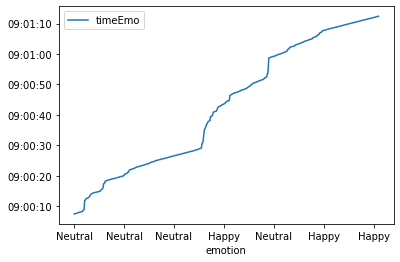

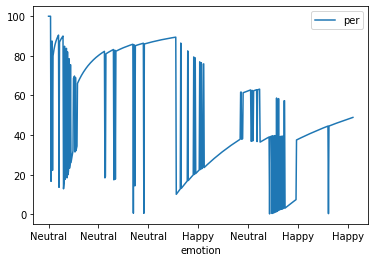

In [8]:
#Save the results in Dataframe for future analysis
df = pd.DataFrame(columns=[])
df['emotion']=predictions
df['timeEmo']=video_timing
df['per']=percentage

ax=plt.gca()
df.plot(kind='line',x='emotion',y='timeEmo', ax=ax)
plt.show()
ax=plt.gca()
df.plot(kind='line',x='emotion',y='per', ax=ax)
plt.show()

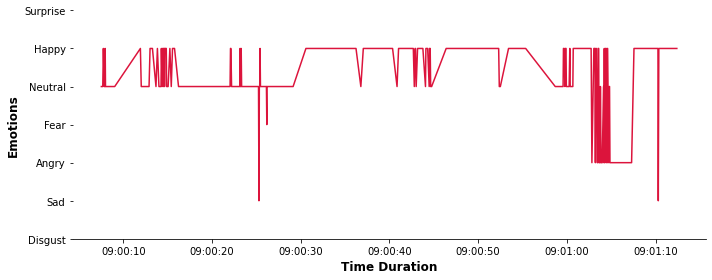

In [9]:
emotions_dict = { "Surprise" : 6, "Happy" : 5, "Neutral" : 4, "Fear" : 3, "Angry" : 2,"Sad" : 1,"Disgust" : 0}
x_axis=video_timing
y_axis = []
for emotions in df['emotion'] :
    y_axis.append(emotions_dict[emotions])
    
fig, axplt = plt.subplots(figsize=(10, 4))
label_format = {'fontsize':12, 'fontweight':'bold'}
title_format = {'fontsize':15, 'fontweight':'bold'}

axplt.plot(x_axis, y_axis, color='crimson', linestyle='-')

#Borders
axplt.spines['top'].set_visible(False)
axplt.spines['right'].set_visible(False)
axplt.spines['left'].set_visible(False)

#Set Labels
axplt.set_xlabel('Time Duration', **label_format)
axplt.set_ylabel('Emotions', **label_format)

#Emotion Values
axplt.set_yticks( list(emotions_dict.values()) )
axplt.set_yticklabels( list(emotions_dict.keys()) )

fig.tight_layout()
plt.show()

In [10]:
final_predictions(predictions,emotions_list)

Happy - Predicted perecentage of Happy % is 88.2


In [23]:
#Run this function to PLAY Video -- business242.mov
cap = cv2.VideoCapture('little_girl_smiling11.mov')
predictions,video_timing,percentage=video_capture(cap)

Fear - 1.78
Happy - 51.56
Neutral - 30.0
Angry - 0.44
Surprise - 14.67
Sad - 0.22
Disgust - 1.33


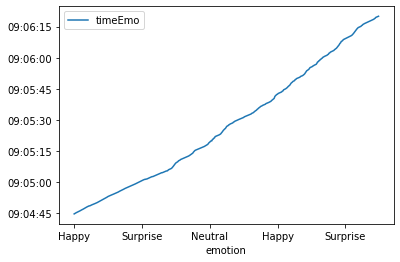

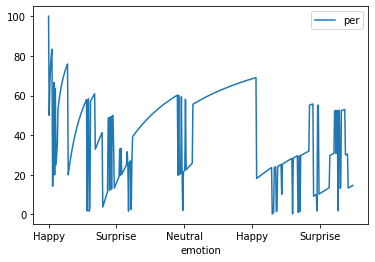

In [16]:
for emotion in set(predictions):
    print ('{} - {}'.format(emotion,(round(predictions.count(emotion)/len(predictions)*100,2))))

df = pd.DataFrame(columns=[])
df['emotion']=predictions
df['timeEmo']=video_timing
df['per']=percentage

ax=plt.gca()
df.plot(kind='line',x='emotion',y='timeEmo', ax=ax)
plt.show()
ax=plt.gca()
df.plot(kind='line',x='emotion',y='per', ax=ax)
plt.show()

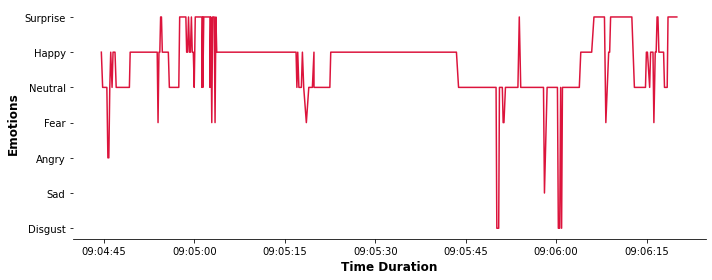

In [17]:
emotions_dict = { "Surprise" : 6, "Happy" : 5, "Neutral" : 4, "Fear" : 3, "Angry" : 2,"Sad" : 1,"Disgust" : 0}
x_axis=video_timing
y_axis = []
for emotions in df['emotion'] :
    y_axis.append(emotions_dict[emotions])
    
fig, axplt = plt.subplots(figsize=(10, 4))
label_format = {'fontsize':12, 'fontweight':'bold'}
title_format = {'fontsize':15, 'fontweight':'bold'}


axplt.plot(x_axis, y_axis, color='crimson', linestyle='-')

axplt.spines['top'].set_visible(False)
axplt.spines['right'].set_visible(False)
axplt.spines['left'].set_visible(False)

axplt.set_xlabel('Time Duration', **label_format)
axplt.set_ylabel('Emotions', **label_format)

### tell matplotlib the ticks and labels to use on Y-axis
axplt.set_yticks( list(emotions_dict.values()) )
axplt.set_yticklabels( list(emotions_dict.keys()) )

fig.tight_layout()
plt.show()

In [22]:
final_predictions(predictions,emotions_list)

Happy - Predicted perecentage of Happy % is 94.60000000000001
